# Rasterize shapefiles and output cropped regions

In [1]:
import os

from PIL import Image

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio import features
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
#import cv2
import matplotlib.pyplot as plt

import glob

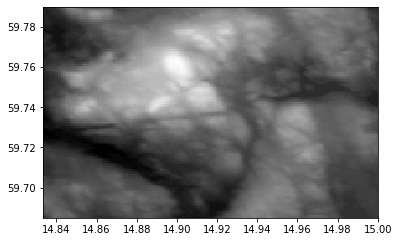

In [22]:
ras = rasterio.open("D:\\Masterarbeit\\Data\\tiles_srtm\\tile660.tif", "r", driver = "GTiff")
show(ras, cmap = "gray")

In [29]:
raster_path = sorted(glob.glob("D:\\Masterarbeit\\Data\\tiles_srtm\\*.tif"))
image_list=[]
ras_list = []
print(raster_path)
# reading rasters from folder in list and plotting them (optionall: uncomment last line)
#for (filename,i) in zip(raster_path[100], range(len(raster_path[100]))):
         #with rasterio.open(filename, "r", driver = "GTiff") as img:
            #raster_img = img.read()
            #im_size = (img.meta['height'], img.meta['width'])
            #print(img.meta)
            #print(raster_img.shape)
            #image_list.append(reshape_as_image(raster_img))
            #image_list.append(raster_img)
            #ras_list.append(img)
            #show(ras_list[i], cmap='gray')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
# reading the training labels with geopandas
annot_path = sorted(glob.glob("D:\\Masterarbeit\\Data\\*.shp"))
annot_list=[]

for filename in annot_path:
    train_df = gpd.read_file(filename)
    train_df['maske'] = 1
    annot_list.append(train_df)
    #print(len(train_df))
    #print(train_df.head(5))

In [27]:
#Function that converts the shapes into rasterized binary masks
def create_binary_masks(im, shape_dicts, name):
    shp_fn = shape_dicts
    out_fn = name.replace(".shp",".tif")
    
    rst = im #Raster as template for the rasterized vector data
    meta = rst.meta.copy()
    meta.update(compress="lzw")
    
    if sum(shape_dicts.geometry.contains(shape_dicts.geometry))!=0:
        
        with rasterio.open(out_fn, 'w+', **meta) as out:
            out_arr = out.read(1)
    #Burning the features into the raster and write out
            polys = ((geom,value) for geom, value in zip(shape_dicts.geometry, shape_dicts.maske))
            burned = features.rasterize(shapes=polys, fill=0, out=out_arr, transform=out.transform)
            out.write_band(1, burned)
            #return(burned)
    else: 
        meta['dtype'] = "int32"
        meta['nodata'] = -99
        with rasterio.open(out_fn, 'w+', **meta) as out:
            out_arr = out.read(1)
            burned = np.zeros([meta["width"],meta["height"]], dtype = int)
            out.write(burned, 1)
            #return(burned)

In [28]:
# Applying the function to all rasters in the list
for (im_fn, ann_fn, file) in zip(ras_list, annot_list, annot_path):
    im = im_fn
    shape_dicts = ann_fn
    name = file
    create_binary_masks(im,shape_dicts, name) 

['annotated\\shapes\\N035W106_AVE_DSM.tif', 'annotated\\shapes\\N035W107_AVE_DSM.tif', 'annotated\\shapes\\N035W108_AVE_DSM.tif', 'annotated\\shapes\\N035W109_AVE_DSM.tif', 'annotated\\shapes\\N035W110_AVE_DSM.tif', 'annotated\\shapes\\N036W106_AVE_DSM.tif', 'annotated\\shapes\\N036W107_AVE_DSM.tif', 'annotated\\shapes\\N036W108_AVE_DSM.tif', 'annotated\\shapes\\N036W109_AVE_DSM.tif', 'annotated\\shapes\\N036W110_AVE_DSM.tif', 'annotated\\shapes\\N037W106_AVE_DSM.tif', 'annotated\\shapes\\N037W107_AVE_DSM.tif']
['images\\N035W106_AVE_DSM.tif', 'images\\N035W107_AVE_DSM.tif', 'images\\N035W108_AVE_DSM.tif', 'images\\N035W109_AVE_DSM.tif', 'images\\N035W110_AVE_DSM.tif', 'images\\N036W106_AVE_DSM.tif', 'images\\N036W107_AVE_DSM.tif', 'images\\N036W108_AVE_DSM.tif', 'images\\N036W109_AVE_DSM.tif', 'images\\N036W110_AVE_DSM.tif', 'images\\N037W106_AVE_DSM.tif', 'images\\N037W107_AVE_DSM.tif']


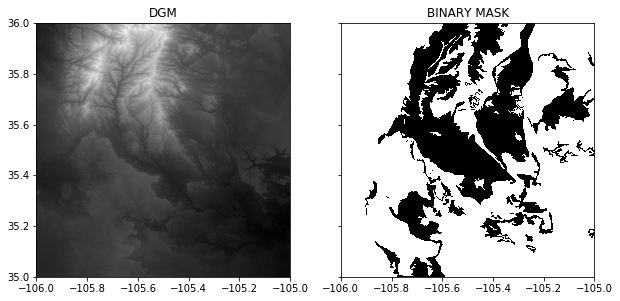

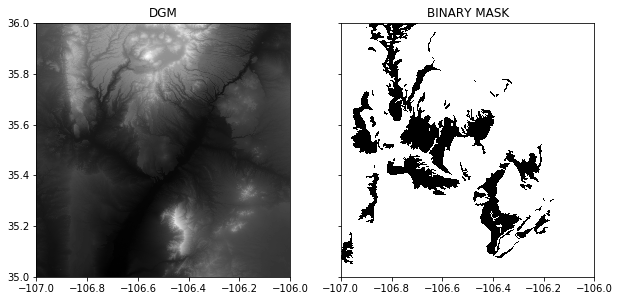

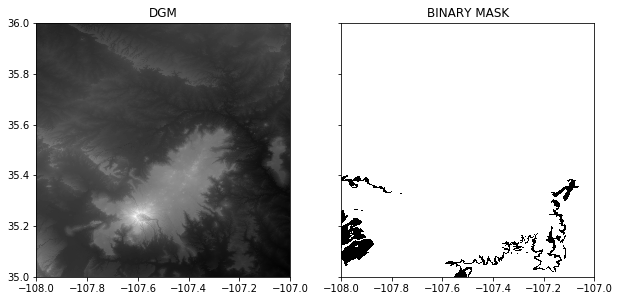

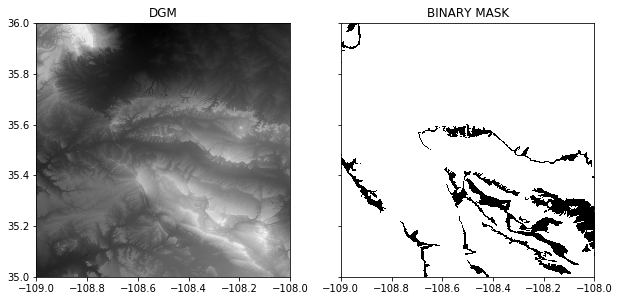

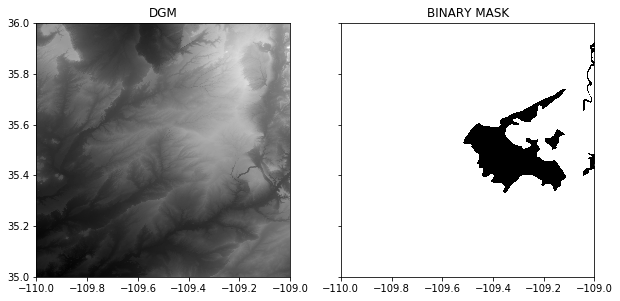

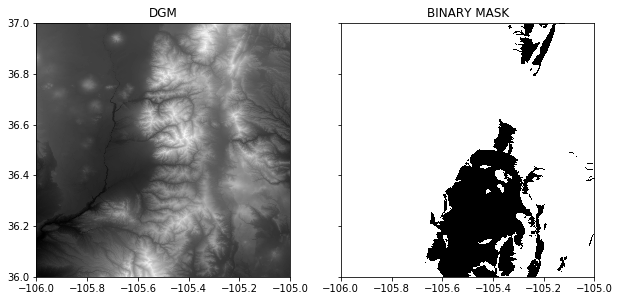

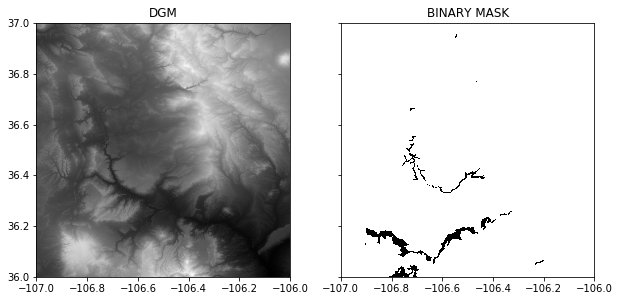

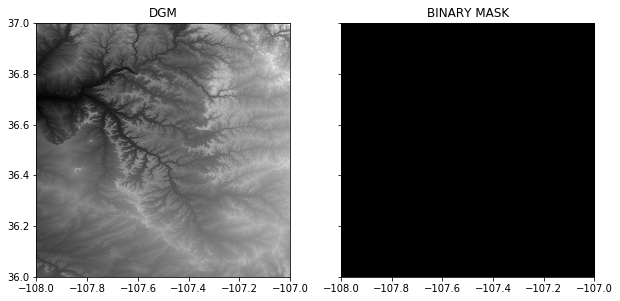

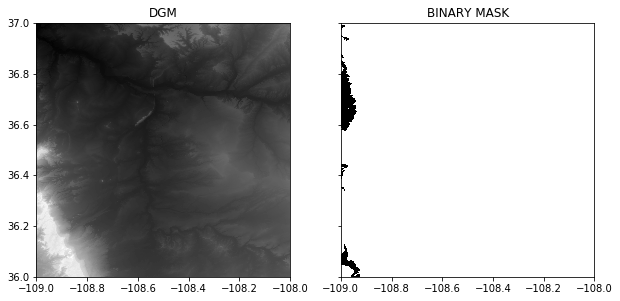

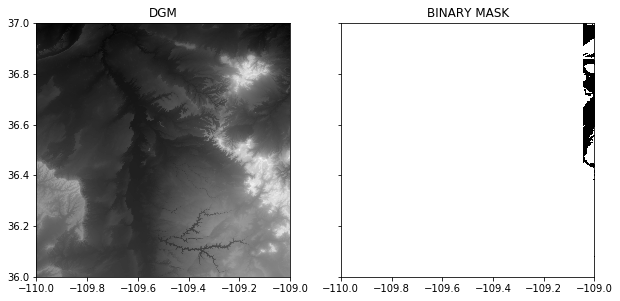

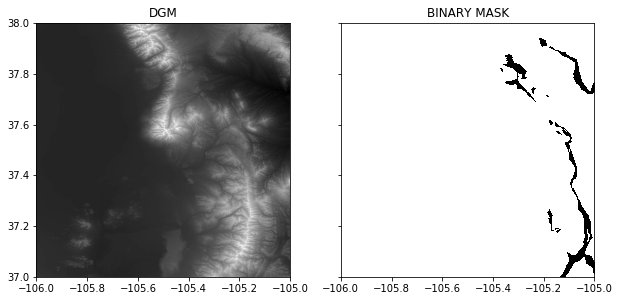

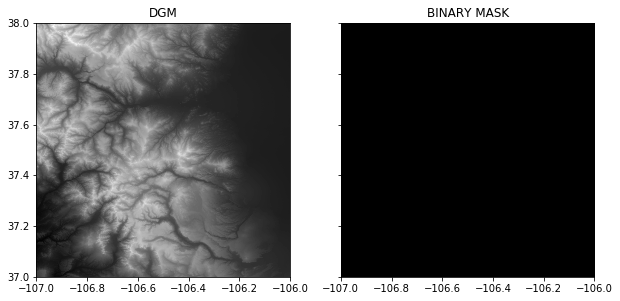

In [40]:
# reading the training labels with geopandas
mask_path = sorted(glob.glob("annotated\shapes\*.tif"))
print(mask_path)

raster_path = sorted(glob.glob("images/*.tif"))
print(raster_path)

#Plotting them together

for i in range(len(ras_list)):
    dgm = rasterio.open(raster_path[i])
    maske = rasterio.open(mask_path[i])
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 8), sharey=True)
    
# Plot Red, Green and Blue (rgb)
    show(dgm, cmap='gray', ax=ax1)
    show(maske, cmap='gray', ax=ax2)

# Add titles
    ax1.set_title("DGM")
    ax2.set_title("BINARY MASK")